# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets

In [2]:
customers = pd.read_csv('/content/drive/MyDrive/Zeotap_Assignment/Customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Zeotap_Assignment/Transactions.csv')

# Convert date columns to datetime

In [4]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])


# Merge datasets

In [5]:
data = transactions.merge(customers, on='CustomerID')

# Feature Engineering

In [6]:
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',               # Total spending
    'TransactionID': 'count',          # Total transactions
    'Quantity': 'sum',                 # Total products purchased
    'Price': 'mean',                   # Average order value
    'Region': 'first'                  # Customer region
}).reset_index()

# One-hot encode the 'Region' column

In [7]:
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Standardize numerical features

In [8]:
scaler = StandardScaler()
numerical_cols = ['TotalValue', 'TransactionID', 'Quantity', 'Price']
customer_features[numerical_cols] = scaler.fit_transform(customer_features[numerical_cols])

# Clustering: Finding the optimal number of clusters using Davies-Bouldin Index

In [9]:
db_scores = []
for k in range(2, 11):  # Clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(customer_features[numerical_cols])
    db_index = davies_bouldin_score(customer_features[numerical_cols], clusters)
    db_scores.append((k, db_index))


# Find the optimal number of clusters

In [10]:
optimal_k = sorted(db_scores, key=lambda x: x[1])[0][0]


# Final clustering with optimal number of clusters

In [11]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features[numerical_cols])


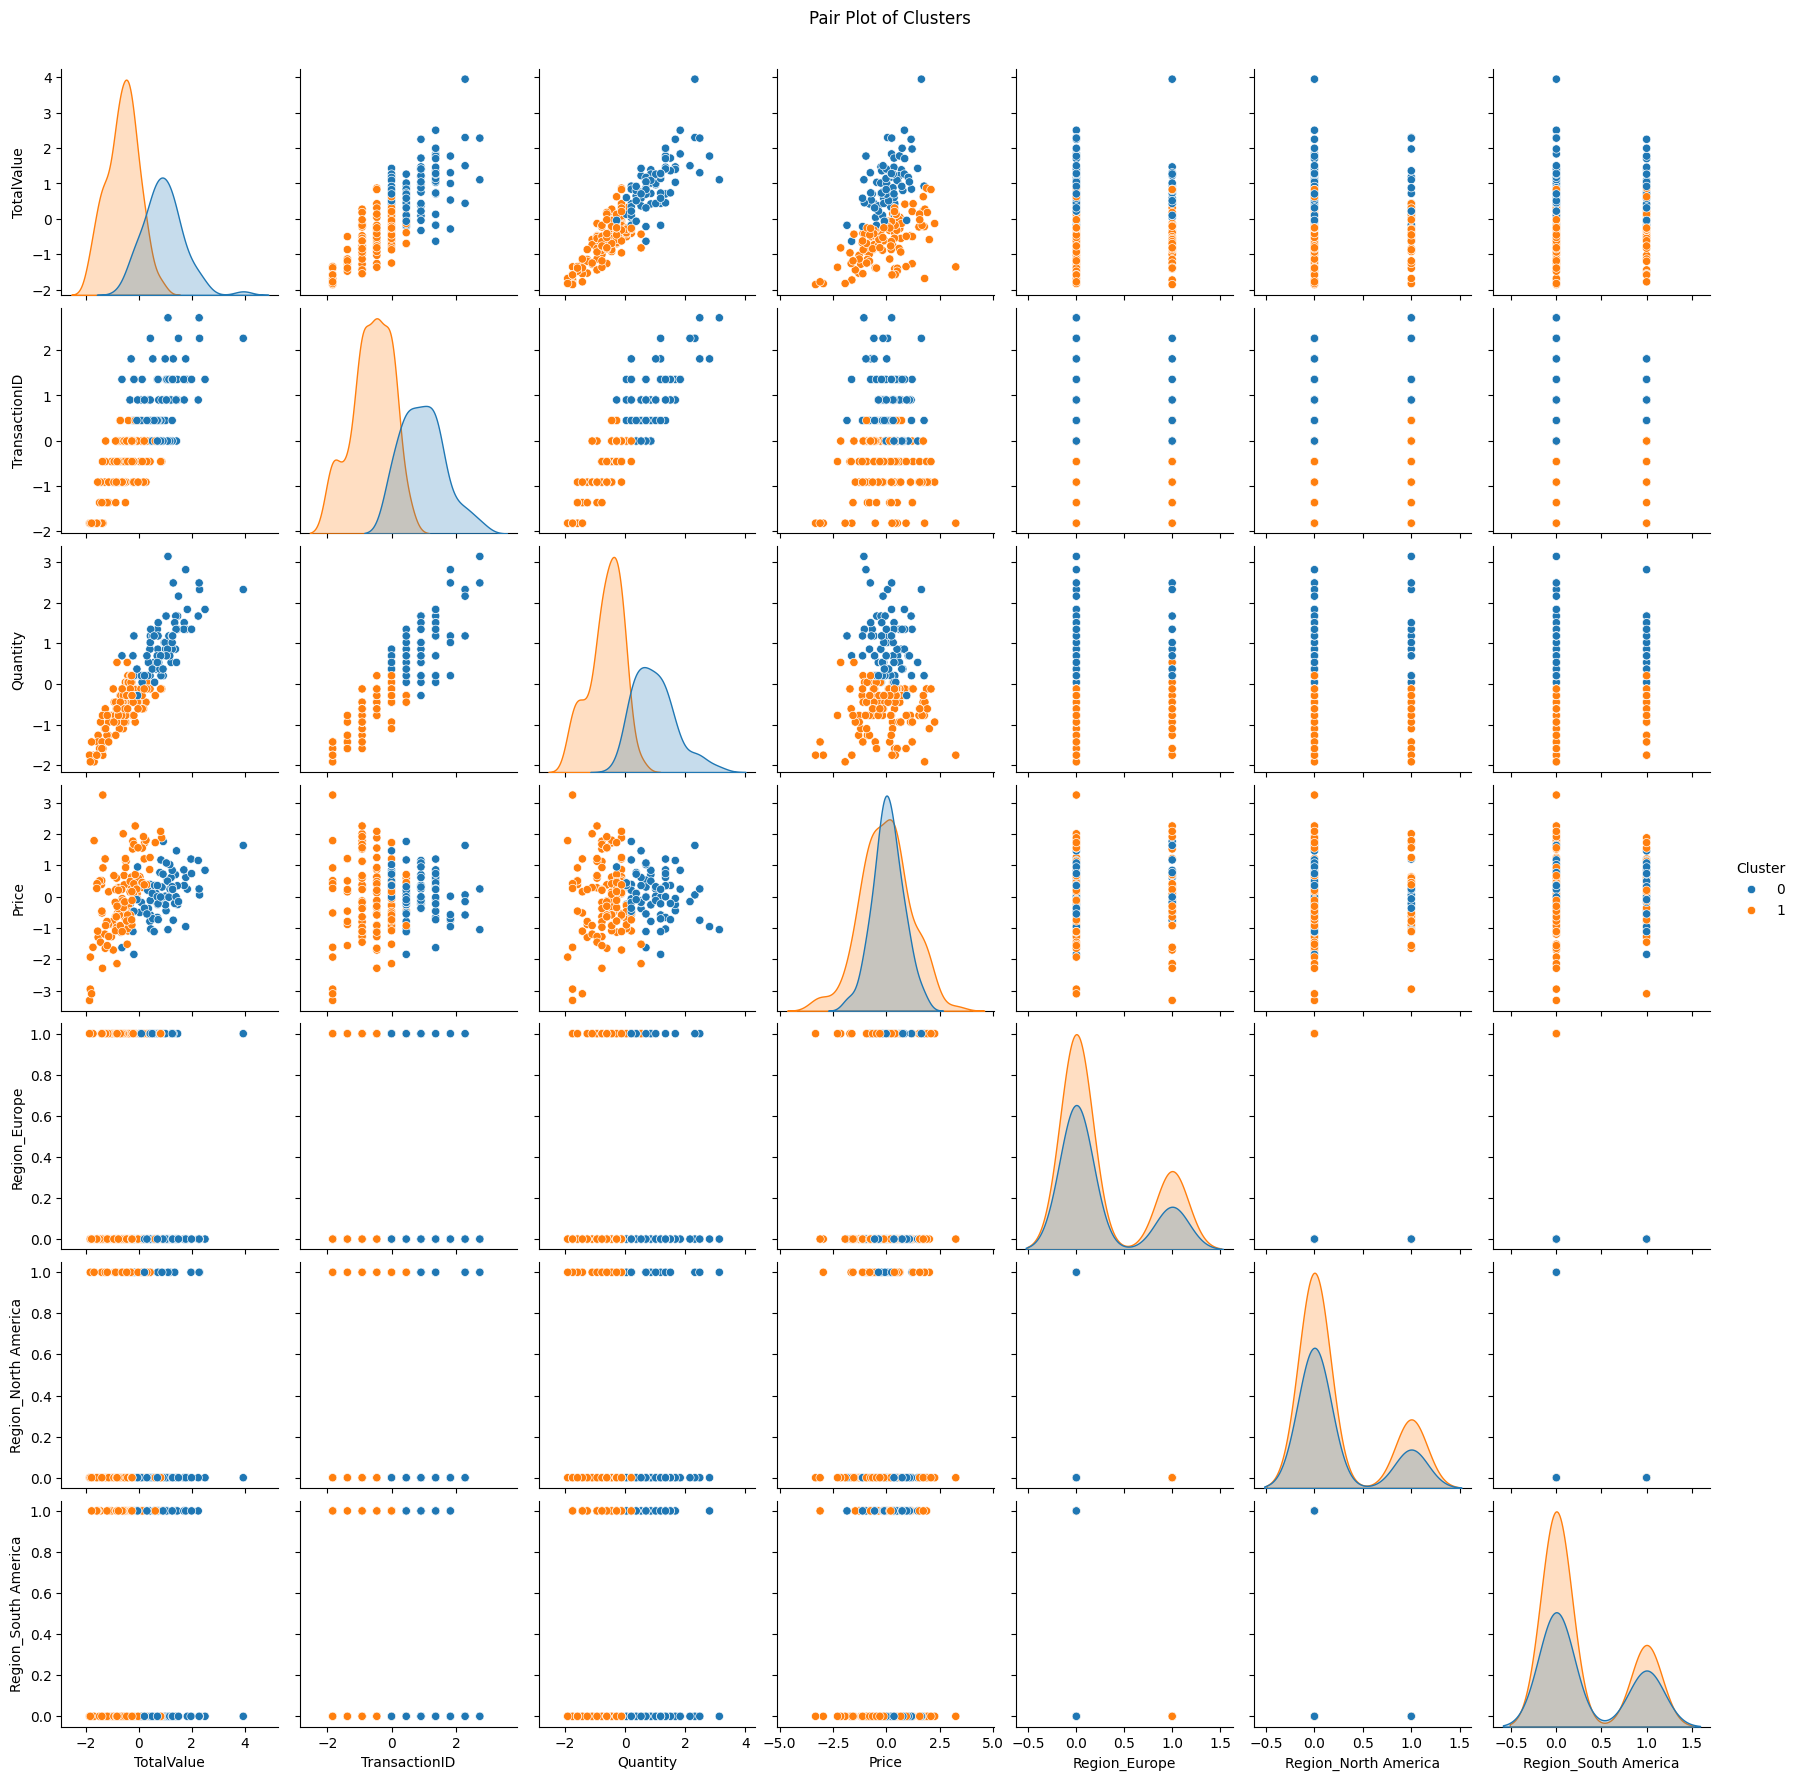

In [12]:
sns.pairplot(customer_features, hue='Cluster', diag_kind='kde', palette='tab10')
plt.suptitle("Pair Plot of Clusters", y=1.02)
plt.show()


# Visualize clusters in 2D using PCA (optional for better interpretation)

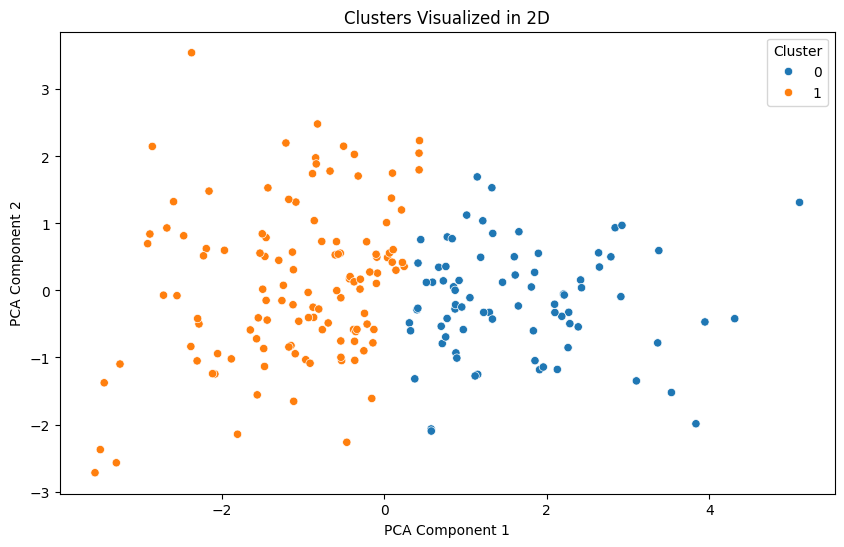

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(customer_features[numerical_cols])
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=customer_features['Cluster'], palette='tab10')
plt.title('Clusters Visualized in 2D')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Output the DB Index and number of clusters

In [16]:
db_index = davies_bouldin_score(customer_features[numerical_cols], customer_features['Cluster'])
print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index(BD Index): {db_index}")


Optimal number of clusters: 2
Davies-Bouldin Index(BD Index): 0.9588140641874352


# Save results to CSV

In [15]:
customer_features.to_csv('CustomerSegmentation.csv', index=False)
print("Customer segmentation results saved to CustomerSegmentation.csv.")

Customer segmentation results saved to CustomerSegmentation.csv.
